In [62]:
import glob
import pylab           as     pl
import pandas          as     pd
import numpy           as     np

from   matplotlib      import pyplot as plt
from   scipy           import stats
from   IPython.display import Image
from   astropy.table   import Table, join, vstack
from   legacy          import cutout

# *Dark Energy Spectroscopic Instrument*

Today, we continue the legacy of Slipher, Hubble, Vera Rubin et al. with the DESI survey of *30 Million* galaxies. 

![title](images/kittpeak.jpg)

To get this many galaxies, we need a telescope big enough to observe very faint galaxies.  With a 4m diameter mirror,  the Mayall Telescope at Kitt Peak is just right.

![title](images/desi_mayall.jpg)

Straight off the telescope, our data looks like:

![title](images/spectra2D.png)

Here you're seeing the light from 500 fibers packed onto a CCD. The horizontal arches correspond to a given wavelength, with the bright lines corresponding to bright sky lines - a complete nuisance!  

The apparently random tracks are cosmic ways - detections of high energy particles generated in the atmosphere.  

We need to carefully calibrate and clean these images to retrieve the galaxy light we really care about.      

In [63]:
redshifts   = Table()
spectra     = Table()

# tracers   = ['mws', bgs', 'lrg', elg', 'qso']
tracers     = ['qso']
tiles       = {'mws': 66003, 'bgs': 66003, 'elg': 67230, 'lrg': 68002, 'qso': 68002}

rfiles      = glob.glob('student_andes/zbest-*')
sfiles      = glob.glob('student_andes/coadd-*')

for tracer in tracers:
  rfile     = 'student_andes/zbest-{}-{}-20200315.fits'.format(tracer, tiles[tracer])    
  redshifts = vstack((redshifts, Table.read(rfile)))

  sfile     = 'student_andes/coadd-{}-{}-20200315.fits'.format(tracer, tiles[tracer]) 
  spectra   = vstack((spectra, Table.read(sfile)))

In [64]:
def Rydberg(n, m):
    # Vacuum wavelengths [nanometres]
    result = 1.096e-2 * (1. / n / n - 1. / m / m)
    return 1. / result

We'll look for the strong lines from Hydrogen (that we learnt about previously) in a few DESI Quasar spectra.

In [65]:
Lya        = 10. * Rydberg(1, 2)

Balmers    = 10. * np.array([Rydberg(2, m) for m in np.arange(6, 3, -1)])
Balmers

array([4105.83941606, 4344.80361488, 4866.18004866])

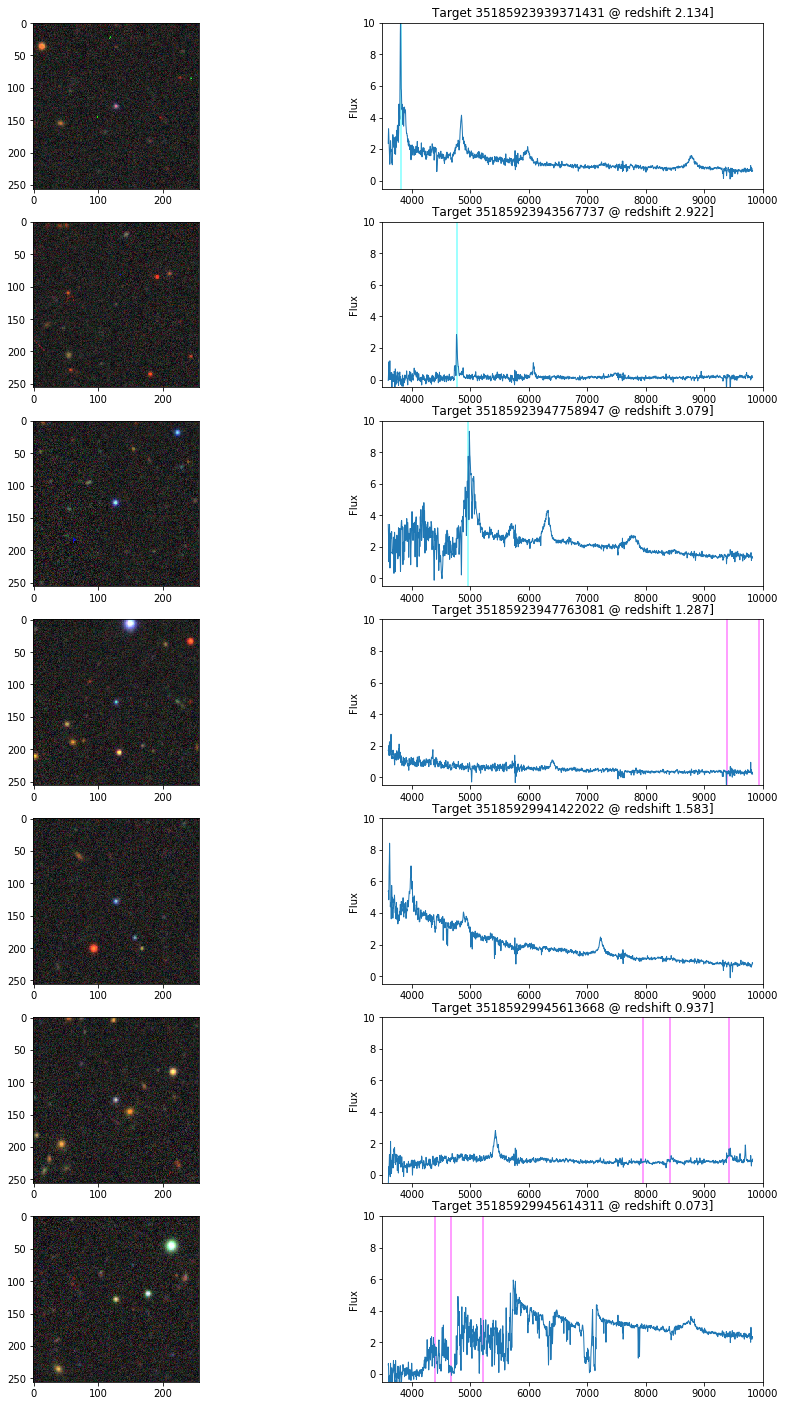

In [58]:
ngal       = 7

fig, axes  = plt.subplots(ngal, 2, figsize=(15., 25.))

for i, tid in enumerate(redshifts['TARGETID'][:ngal]):
  redshift = redshifts['Z'][i]
    
  axes[i,1].axvline((1. + redshift) * Lya, c='cyan', alpha=0.5)
  
  for balmer in Balmers:
    axes[i,1].axvline((1. + redshift) * balmer, c='magenta', alpha=0.5)      
    
  axes[i,1].plot(spectra['WAVELENGTH'], spectra['TARGET{:d}'.format(tid)], lw=1)
  axes[i,1].set_title('Target {} @ redshift {:.3f}]'.format(tid, redshift))
  
  axes[i,1].set_xlim(3.5e3, 1.e4)
  axes[i,1].set_ylim(-0.5, 10.)

  axes[i,1].set_ylabel('Flux')
    
  cutout(axes[i,0], redshifts['TARGET_RA'][i], redshifts['TARGET_DEC'][i])

Notice how the Hydrogen lines we see are very broad.  This is because the Hydrogen is rapidly moving within the glaxy itself. 

In [68]:
# pl.semilogy(redshifts['Z'], redshifts['FLUX_Z'], c='k', marker='*', lw=0.0)